## 单独每个神经元计算VOI，统计相应的采样点数

In [1]:
import imageio
from funlib.evaluate import rand_voi
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import random
import numpy as np

In [2]:
label = imageio.imread('./label_z0.tiff')

seg1 = imageio.imread('./MedSAM(failed).tif')
seg2 = imageio.imread('./microsam.tiff')
seg3 = imageio.imread('./napari-sam(h).tiff')
seg4 = imageio.imread('./UniSPAC(one-by-one).tiff')
seg5 = imageio.imread('./UniSPAC(automatic+proofread).tiff')

method_names = ['MedSAM','micro-sam', 'napari-SAM', 'UniSPAC(one-by-one)','UniSPAC(automatic+proofread)']

/tmp/ipykernel_1118451/1368346257.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = imageio.imread('./label_z0.tiff')
/tmp/ipykernel_1118451/1368346257.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  seg1 = imageio.imread('./MedSAM(failed).tif')
/tmp/ipykernel_1118451/1368346257.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  seg2 = imageio.imread('./microsam.tiff'

## 统计MicroSAM的结果

/tmp/ipykernel_1118451/1204238308.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  raw = imageio.imread('./raw_z0.tiff')


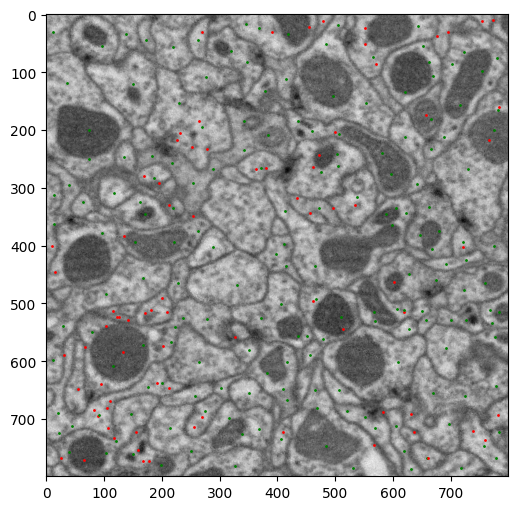

In [3]:
raw = imageio.imread('./raw_z0.tiff')

fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(111)
ax.imshow(raw, cmap='gray')


for n_file in range(1, 87):
    file_name = 'point_prompts copy [{}].csv'.format(n_file)
    data = pd.read_csv('./microsam(points)/{}'.format(file_name)).values.tolist()
    
    for item in data:
        if item[-1] == 'positive':
            ax.scatter(item[2], item[1], c='green', s=1)
        else:
            ax.scatter(item[2], item[1], c='red', s=1)

In [4]:
import pandas as pd
import numpy as np

micro_sam_dict = {'VOI':[], 'num_prompts':[]}

for n_file in tqdm(range(1, 87)):
    file_name = 'point_prompts copy [{}].csv'.format(n_file)
    data = pd.read_csv('./microsam(points)/{}'.format(file_name)).values.tolist()
    n_prompts = len(data)
    
    ##添加提示数量
    micro_sam_dict['num_prompts'].append(n_prompts)
    
    ##计算当前神经元的VOI
    pos_c = int(data[0][1])
    pos_r = int(data[0][2])
    
    index_neuron_seg = seg2[pos_r, pos_c]
    seg_neuron = (seg2 == index_neuron_seg).astype(int)
    index_neuron_lab = label[pos_r, pos_c]
    lab_neuron = (label == index_neuron_lab).astype(int)
    
    ##计算VOI
    rand_voi_report = rand_voi(
                    np.array(lab_neuron, dtype=np.uint64),
                    np.array(seg_neuron, dtype=np.uint64),
                    return_cluster_scores=False)

    metrics = rand_voi_report.copy()
    # print("voi = {:.4f}, voi split = {:.4f}, voi merge = {:.4f}".format(
    #     metrics['voi_split'] + metrics['voi_merge'],
    #     metrics['voi_split'],
    #     metrics['voi_merge']))
    voi = metrics['voi_split'] + metrics['voi_merge']
    micro_sam_dict['VOI'].append(voi)
    

 33%|███▎      | 28/86 [00:00<00:00, 128.36it/s]

100%|██████████| 86/86 [00:00<00:00, 129.62it/s]


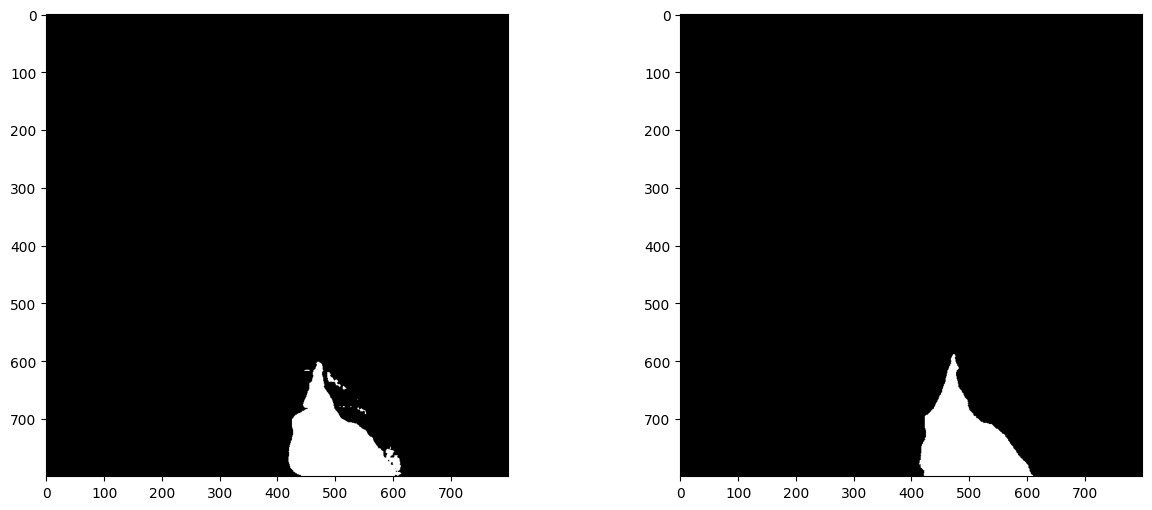

In [5]:
fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(121)
ax.imshow(seg_neuron, cmap='gray')

ax = fig.add_subplot(122)
ax.imshow(lab_neuron, cmap='gray')

## 统计MedSAM的结果

In [6]:
neuron_prompt_dict = dict()
data = pd.read_csv('./MedSAM.csv').values.tolist()
for item in data:
    pos_c = int(item[1])
    pos_r = int(item[2])
    
    index_neuron_lab = label[pos_r, pos_c]
    if index_neuron_lab not in neuron_prompt_dict.keys():
        neuron_prompt_dict[index_neuron_lab] = [(pos_r, pos_c)]
    else:
        neuron_prompt_dict[index_neuron_lab].append((pos_r, pos_c))
        
print("标注了{}个神经元".format(len(neuron_prompt_dict.keys())))

标注了33个神经元


In [7]:
medsam_dict = {'VOI':[], 'num_prompts':[]}

for index_neuron_lab in list(neuron_prompt_dict.keys())[::-1]:
    
    lab_neuron = (label == index_neuron_lab).astype(int)

    
    index_neuron_seg = list()
    for (pos_r, pos_c) in neuron_prompt_dict[index_neuron_lab]:
        pos_r, pos_c = neuron_prompt_dict[index_neuron_lab][0]
        index_neuron_seg.append(seg1[pos_r, pos_c])
    counts = np.bincount(index_neuron_seg)
    index_neuron_seg = np.argmax(counts) #取众数
    seg_neuron = (seg1 == index_neuron_seg).astype(int)
    
    ##计算VOI
    rand_voi_report = rand_voi(
                    np.array(lab_neuron, dtype=np.uint64),
                    np.array(seg_neuron, dtype=np.uint64),
                    return_cluster_scores=False)
    metrics = rand_voi_report.copy()
    voi = metrics['voi_split'] + metrics['voi_merge']
    medsam_dict['VOI'].append(voi)
    
    medsam_dict['num_prompts'].append(len(neuron_prompt_dict[index_neuron_lab]))


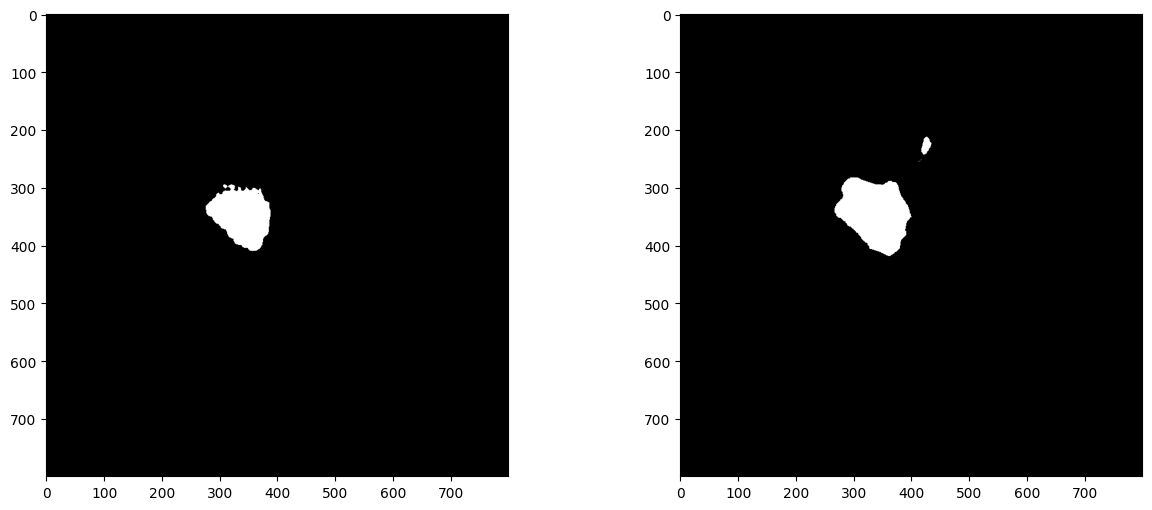

In [8]:
fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(121)
ax.imshow(seg_neuron, cmap='gray')

ax = fig.add_subplot(122)
ax.imshow(lab_neuron, cmap='gray')

## 统计SAM的结果

In [9]:
neuron_prompt_dict = dict()
data = pd.read_csv('./napari-sam(h).csv').values.tolist()
for item in data:
    pos_c = int(item[1])
    pos_r = int(item[2])
    
    index_neuron_lab = label[pos_r, pos_c]
    if index_neuron_lab not in neuron_prompt_dict.keys():
        neuron_prompt_dict[index_neuron_lab] = [(pos_r, pos_c)]
    else:
        neuron_prompt_dict[index_neuron_lab].append((pos_r, pos_c))
        
print("标注了{}个神经元".format(len(neuron_prompt_dict.keys())))

标注了63个神经元


In [10]:
sam_dict = {'VOI':[], 'num_prompts':[]}

for index_neuron_lab in list(neuron_prompt_dict.keys())[::-1]:
    
    lab_neuron = (label == index_neuron_lab).astype(int)

    
    index_neuron_seg = list()
    for (pos_r, pos_c) in neuron_prompt_dict[index_neuron_lab]:
        pos_r, pos_c = neuron_prompt_dict[index_neuron_lab][0]
        index_neuron_seg.append(seg3[pos_r, pos_c])
    counts = np.bincount(index_neuron_seg)
    index_neuron_seg = np.argmax(counts) #取众数
    seg_neuron = (seg3 == index_neuron_seg).astype(int)
    
    ##计算VOI
    rand_voi_report = rand_voi(
                    np.array(lab_neuron, dtype=np.uint64),
                    np.array(seg_neuron, dtype=np.uint64),
                    return_cluster_scores=False)
    metrics = rand_voi_report.copy()
    voi = metrics['voi_split'] + metrics['voi_merge']
    sam_dict['VOI'].append(voi)
    
    sam_dict['num_prompts'].append(len(neuron_prompt_dict[index_neuron_lab]))


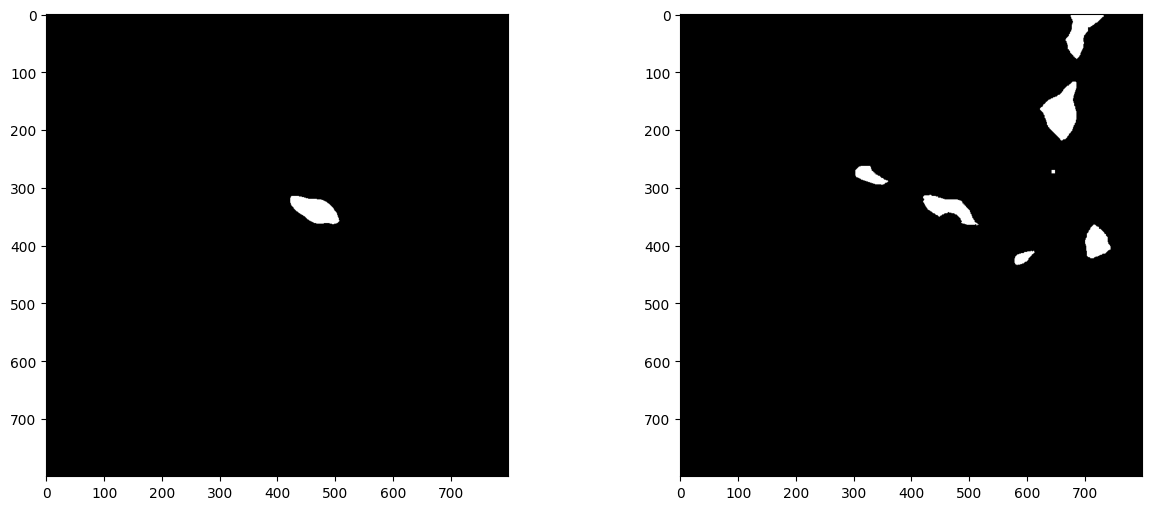

In [11]:
fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(121)
ax.imshow(seg_neuron, cmap='gray')

ax = fig.add_subplot(122)
ax.imshow(lab_neuron, cmap='gray')

## 统计UniSPAC(one-by-one)的结果

In [12]:
neuron_prompt_dict = dict()
data = pd.read_csv('./UniSPAC(one-by-one).csv').values.tolist()
for item in data:
    pos_c = int(item[1])
    pos_r = int(item[2])
    
    index_neuron_lab = label[pos_r, pos_c]
    if index_neuron_lab not in neuron_prompt_dict.keys():
        neuron_prompt_dict[index_neuron_lab] = [(pos_r, pos_c)]
    else:
        neuron_prompt_dict[index_neuron_lab].append((pos_r, pos_c))
        
print("标注了{}个神经元".format(len(neuron_prompt_dict.keys())))

标注了65个神经元


In [13]:
UniSPAC_obo_dict = {'VOI':[], 'num_prompts':[]}

for index_neuron_lab in list(neuron_prompt_dict.keys())[::-1]:
    
    lab_neuron = (label == index_neuron_lab).astype(int)

    
    index_neuron_seg = list()
    for (pos_r, pos_c) in neuron_prompt_dict[index_neuron_lab]:
        pos_r, pos_c = neuron_prompt_dict[index_neuron_lab][0]
        index_neuron_seg.append(seg4[pos_r, pos_c])
    counts = np.bincount(index_neuron_seg)
    index_neuron_seg = np.argmax(counts) #取众数
    seg_neuron = (seg4 == index_neuron_seg).astype(int)
    
    ##计算VOI
    rand_voi_report = rand_voi(
                    np.array(lab_neuron, dtype=np.uint64),
                    np.array(seg_neuron, dtype=np.uint64),
                    return_cluster_scores=False)
    metrics = rand_voi_report.copy()
    voi = metrics['voi_split'] + metrics['voi_merge']
    UniSPAC_obo_dict['VOI'].append(voi)
    
    UniSPAC_obo_dict['num_prompts'].append(len(neuron_prompt_dict[index_neuron_lab]))


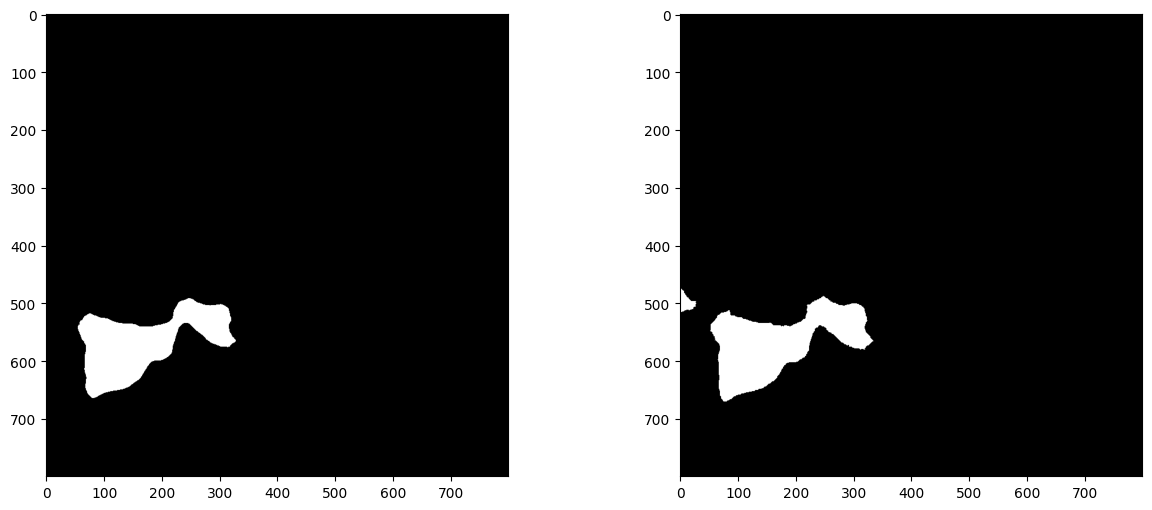

In [14]:
fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(121)
ax.imshow(seg_neuron, cmap='gray')

ax = fig.add_subplot(122)
ax.imshow(lab_neuron, cmap='gray')

## 统计UniSPAC(auto+proof)的结果

In [15]:
index_neuron_seg_list = np.unique(seg5)
print("标注了{}个神经元".format(len(index_neuron_seg_list)))

标注了185个神经元


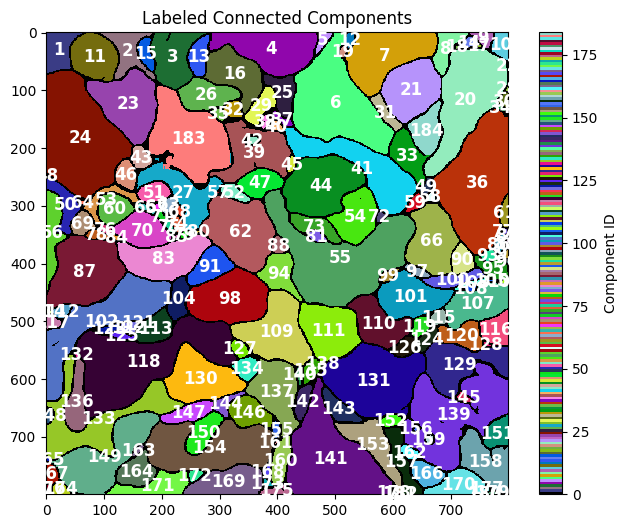

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import ndimage

def plot_labeled_components(X):
    # 获取所有连通域编号（排除0背景）
    labels = np.unique(X)
    if 0 in labels:
        labels = labels[labels != 0]
    
    # 生成随机颜色
    colors = np.random.rand(len(labels)+1, 3)  # +1为背景预留位置
    colors[0] = [0,0,0]  # 背景设为黑色
    
    # 创建颜色映射
    cmap = mcolors.ListedColormap(colors)
    
    # 创建图像
    plt.figure(figsize=(8,6))
    plt.imshow(X, cmap=cmap, interpolation='none')
    
    # 计算每个连通域的质心并标注
    for label in labels:
        # 创建当前连通域的掩膜
        mask = (X == label)
        
        # 计算质心（中心坐标）
        center = ndimage.center_of_mass(mask)
        
        # 标注文本（调整位置使文字居中）
        plt.text(center[1], center[0], str(label), 
                 ha='center', va='center',
                 color='white', fontsize=12, fontweight='bold')
    
    plt.colorbar(label="Component ID")
    plt.title("Labeled Connected Components")
    plt.show()


plot_labeled_components(seg5)

In [17]:
UniSPAC_autoP_dict = {'VOI':[], 'num_prompts':[]}

for index_neuron_seg in tqdm(index_neuron_seg_list):
    
    seg_neuron = (seg5 == index_neuron_seg).astype(int)

    # index_neuron_lab = label[seg_neuron == 1].tolist()
    # counts = np.bincount(index_neuron_lab)
    # index_neuron_lab = np.argmax(counts) #取众数
    # lab_neuron = (label == index_neuron_lab).astype(int)
        
    # 计算质心（中心坐标）
    center = ndimage.center_of_mass(seg_neuron)
    index_neuron_lab = label[int(center[0]), int(center[1])]
    lab_neuron = (label == index_neuron_lab).astype(int)
    
    ##计算VOI
    rand_voi_report = rand_voi(
                    np.array(lab_neuron, dtype=np.uint64),
                    np.array(seg_neuron, dtype=np.uint64),
                    return_cluster_scores=False)
    metrics = rand_voi_report.copy()
    voi = metrics['voi_split'] + metrics['voi_merge']
    UniSPAC_autoP_dict['VOI'].append(voi)
    
    if index_neuron_seg not in [183, 184]:
        UniSPAC_autoP_dict['num_prompts'].append(0)
    elif index_neuron_seg == 183:
        UniSPAC_autoP_dict['num_prompts'].append(15)
    elif index_neuron_seg == 184:
        UniSPAC_autoP_dict['num_prompts'].append(2)


100%|██████████| 185/185 [00:01<00:00, 100.95it/s]


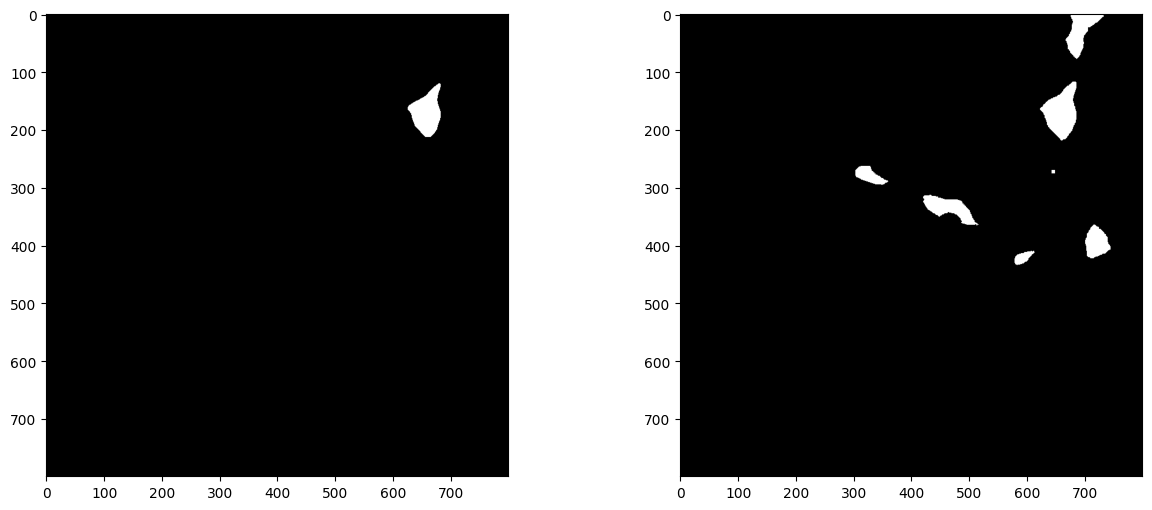

In [18]:
fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(121)
ax.imshow(seg_neuron, cmap='gray')

ax = fig.add_subplot(122)
ax.imshow(lab_neuron, cmap='gray')

## 共同显示VOI和num_prompts

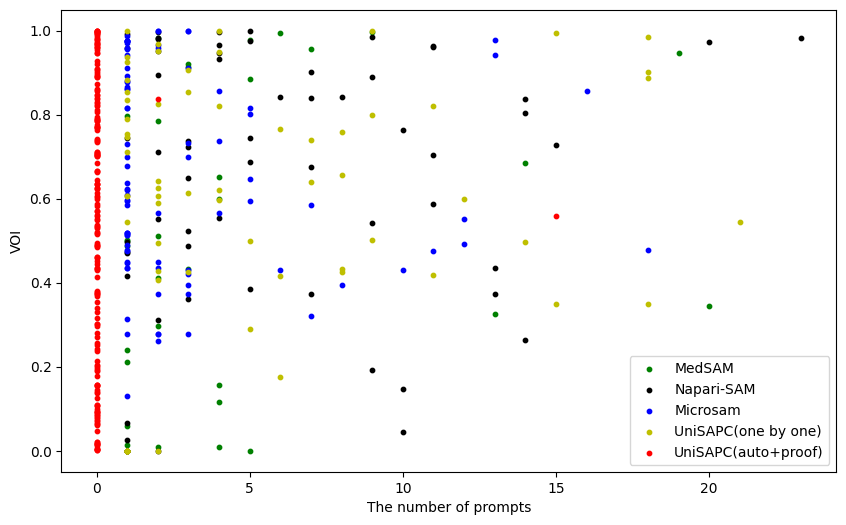

In [19]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

point_size = 10

plt.figure(figsize=(10, 6))
plt.scatter(medsam_dict['num_prompts'], medsam_dict['VOI'], c='g', s=point_size)
plt.scatter(sam_dict['num_prompts'], sam_dict['VOI'], c='k', s=point_size)
plt.scatter(micro_sam_dict['num_prompts'], micro_sam_dict['VOI'], c='b', s=point_size)
plt.scatter(UniSPAC_obo_dict['num_prompts'], UniSPAC_obo_dict['VOI'], c='y', s=point_size)
plt.scatter(UniSPAC_autoP_dict['num_prompts'], UniSPAC_autoP_dict['VOI'], c='r', s=point_size)

plt.legend(['MedSAM', 'Napari-SAM', 'Microsam', 'UniSAPC(one by one)', 'UniSAPC(auto+proof)'])
plt.ylabel('VOI')
plt.xlabel('The number of prompts')

plt.savefig('./figure2c_extend.pdf', dpi=300) 